[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nlebovits/datos-escala-humana/blob/main/es/datos-accion/unidad_4_soluciones.ipynb)

---
title: 'ACP 166: Datos abiertos para ciudades resilientes'
subtitle: 'Unidad 4: De los datos a la acción'
---

## Objetivos

Enfocarse en cómo aplicar datos en el contexto de toma de decisiones robustas. Usaremos el caso de Esperanza (Santa Fe) con datos de peligro de inundación fluvial y exposición para generar recomendaciones e intervenciones concretas vinculadas al marco de toma de decisiones robustas bajo cambio climático.

## Contexto

Esperanza es un municipio de aproximadamente 45.000 habitantes en Santa Fe, ubicado junto a un río. Históricamente ha tenido problemas con inundaciones pluviales (desde el sudoeste, por escurrimiento de campos agrícolas saturados) y fluviales (a lo largo del río). Dos eventos destacados: 2003 y 2016. Los datos utilizados aquí son reales y fueron empleados para decisiones reales del municipio. Acá, enfocamos solamente en la cuestión de las inundaciones fluviales.

## Instrucciones

Entregables:
- Una diapositiva explicando los hallazgos del análisis
- Una diapositiva explicando la intervención propuesta y por qué representa toma de decisiones robusta

Requisitos:
- Calcular las métricas que consideren apropiadas (población expuesta, % de población expuesta, área agrícola expuesta, área total, etc.)
- Conectar el análisis con UNA intervención específica (estructural o no estructural)
- Explicar POR QUÉ es una decisión robusta

Pueden usar cualquier escenario climático y cualquier métrica. La responsabilidad es elegir datos y métricas apropiadas, comunicarlos claramente, y explicar cómo los usan para tomar decisiones robustas e informadas por datos para el municipio.

## Datos
Datos disponibles:
- Inundaciones históricas (2003, 2016) - polígonos vectoriales proporcionados por el municipio
- Límites municipales - Instituto Geográfico Nacional
- Tres escenarios de inundación (RP20, RP100, RP500) - profundidad de inundación, Joint Research Commission
- Densidad de población - GHSL, Joint Research Commission
- Cobertura de suelo 2022 - MapBiomas
Estos datos permiten proponer intervenciones estructurales o no estructurales. Deben elegir un tipo de intervención y justificar la elección.

Nota: Asumir que todos los datos son correctos y están validados. No se incluyen proyecciones climáticas. Este es un ejercicio simplificado para el taller, enfocado en cómo convertir datos en decisiones robustas.

In [8]:
import zipfile
from pathlib import Path
import urllib.request
from io import BytesIO
import geopandas as gpd
import rioxarray
import folium
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import base64

# Descargar y extraer datos
url = "https://arg-fulbright-data.s3.us-east-2.amazonaws.com/esperanza/datos_esperanza_3857.zip"
extract_dir = Path("datos_esperanza")
extract_dir.mkdir(exist_ok=True)

with urllib.request.urlopen(url) as response:
    zip_data = response.read()
with zipfile.ZipFile(BytesIO(zip_data), 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Cargar datos vectoriales directamente en WGS84
inundacion_2016 = gpd.read_file(extract_dir / "inundacion_historica_2016.geojson").to_crs("EPSG:4326")
inundacion_2003 = gpd.read_file(extract_dir / "inundacion_historica_2003.geojson").to_crs("EPSG:4326")
limite_esperanza = gpd.read_file(extract_dir / "limite_esperanza.geojson").to_crs("EPSG:4326")

# Cargar datos raster directamente en WGS84
profundidad_rp20 = rioxarray.open_rasterio(extract_dir / "profundidad_inundacion_rp20.tif").rio.reproject("EPSG:4326").load()
profundidad_rp100 = rioxarray.open_rasterio(extract_dir / "profundidad_inundacion_rp100.tif").rio.reproject("EPSG:4326").load()
profundidad_rp500 = rioxarray.open_rasterio(extract_dir / "profundidad_inundacion_rp500.tif").rio.reproject("EPSG:4326").load()
densidad_poblacion = rioxarray.open_rasterio(extract_dir / "densidad_poblacion.tif").rio.reproject("EPSG:4326").load()
cobertura_suelo = rioxarray.open_rasterio(extract_dir / "cobertura_suelo_2022.tif").rio.reproject("EPSG:4326").load()


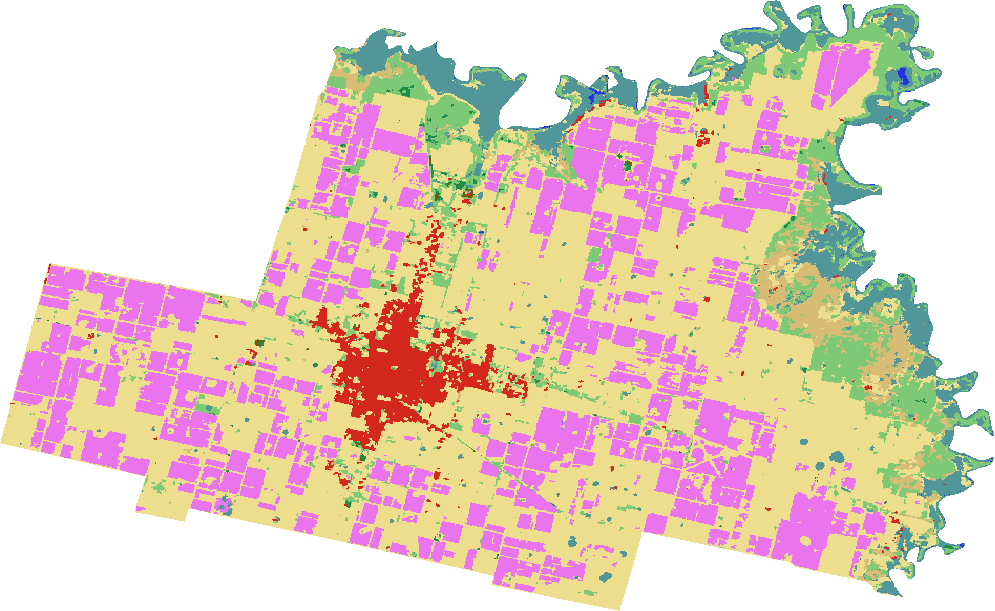
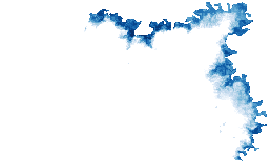
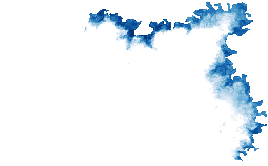
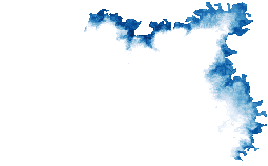
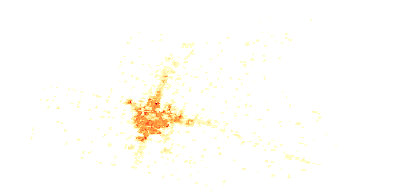

In [9]:
# Paleta de colores para cobertura de suelo
categories_detailed = {
    "Leñosa cerrada": {"ids": [3], "color": "#1f8d49"},
    "Leñosa abierta": {"ids": [4], "color": "#7dc975"},
    "Leñosa dispersa": {"ids": [45], "color": "#807a40"},
    "Leñosa inundable": {"ids": [6], "color": "#026975"},
    "Vegetación no leñosa inundable": {"ids": [11], "color": "#519799"},
    "Pastizal": {"ids": [12], "color": "#d6bc74"},
    "Estepa": {"ids": [63], "color": "#ebf8b5"},
    "Pastura": {"ids": [15], "color": "#edde8e"},
    "Agricultura": {"ids": [18], "color": "#e974ed"},
    "Plantación forestal": {"ids": [9], "color": "#7a5900"},
    "Cultivo arbustivo": {"ids": [36], "color": "#d082de"},
    "Mosaico agropecuario": {"ids": [21], "color": "#ffefc3"},
    "Área sin vegetación": {"ids": [22], "color": "#d4271e"},
    "Río, lago u océano": {"ids": [33], "color": "#2532e4"},
    "Hielo y nieve en superficie": {"ids": [34], "color": "#93dfe6"},
    "No observado": {"ids": [27], "color": "#ffffff"},
}
colors = {pixel_id: info["color"] for category, info in categories_detailed.items() for pixel_id in info["ids"]}

# Crear mapa
bounds = limite_esperanza.total_bounds
center_lat, center_lon = (bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles=None)

# Basemap satelital
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Satellite",
    overlay=False,
    control=False,
).add_to(m)

# Límite (ON por defecto)
folium.GeoJson(
    limite_esperanza,
    style_function=lambda feature: {"fillColor": "none", "color": "black", "weight": 2, "fillOpacity": 0},
    name="Límite Esperanza",
    show=True,
).add_to(m)

# Cobertura de suelo (ON por defecto, enmascarar valores 0)
def add_raster_overlay(raster, name, cmap_name, opacity=0.7, show=True, mask_zero=False):
    array = raster.squeeze().values.astype(float)
    if mask_zero:
        array[array == 0] = np.nan
    valid_mask = ~np.isnan(array) & np.isfinite(array) & (array > 0 if not mask_zero else True)
    
    if not valid_mask.any():
        return
    
    if mask_zero and name == "Cobertura de suelo":
        # Colormap categórico para cobertura de suelo
        unique_vals = np.unique(array[valid_mask]).astype(int)
        cmap_colors = [colors.get(int(v), "#808080") for v in sorted(unique_vals)]
        cmap = mcolors.ListedColormap(cmap_colors)
        bounds_vals = sorted(unique_vals)
        normalized = np.full_like(array, np.nan, dtype=np.float32)
        for i, val in enumerate(bounds_vals):
            normalized[array == val] = i / (len(bounds_vals) - 1) if len(bounds_vals) > 1 else 0
    else:
        # Colormap continuo
        vmin, vmax = np.nanmin(array[valid_mask]), np.nanmax(array[valid_mask])
        normalized = np.full_like(array, 0, dtype=np.float32)
        normalized[valid_mask] = (array[valid_mask] - vmin) / (vmax - vmin)
        cmap = plt.get_cmap(cmap_name)
    
    rgba = cmap(normalized)
    rgba[~valid_mask, 3] = 0
    rgba = (rgba * 255).astype(np.uint8)
    
    img = Image.fromarray(rgba, "RGBA")
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    img_base64 = base64.b64encode(buffer.getvalue()).decode()
    
    bounds_geo = raster.rio.bounds()
    bounds_list = [[bounds_geo[1], bounds_geo[0]], [bounds_geo[3], bounds_geo[2]]]
    
    folium.raster_layers.ImageOverlay(
        image=f"data:image/png;base64,{img_base64}",
        bounds=bounds_list,
        opacity=opacity,
        interactive=True,
        name=name,
        show=show,
    ).add_to(m)

add_raster_overlay(cobertura_suelo, "Cobertura de suelo", None, show=True, mask_zero=True)

# Inundaciones históricas (OFF por defecto)
folium.GeoJson(inundacion_2016, style_function=lambda f: {"fillColor": "blue", "color": "blue", "weight": 1, "fillOpacity": 0.5}, name="Inundación histórica 2016", show=False).add_to(m)
folium.GeoJson(inundacion_2003, style_function=lambda f: {"fillColor": "cyan", "color": "cyan", "weight": 1, "fillOpacity": 0.5}, name="Inundación histórica 2003", show=False).add_to(m)

# Profundidad de inundación (OFF por defecto)
for raster, name in [(profundidad_rp20, "Profundidad inundación RP20"), (profundidad_rp100, "Profundidad inundación RP100"), (profundidad_rp500, "Profundidad inundación RP500")]:
    add_raster_overlay(raster, name, "Blues", opacity=0.6, show=False)

# Densidad de población (OFF por defecto)
add_raster_overlay(densidad_poblacion, "Densidad de población", "YlOrRd", opacity=0.6, show=False)

folium.LayerControl().add_to(m)
m